In [18]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для разделения данных и нормализации
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Для второй модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Для виджетов
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown


In [19]:
df = pd.read_csv("housing.csv")
print(df.shape)
print(df.head())
print(df.columns.tolist())


(20640, 10)
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 

In [20]:
median_price = df['median_house_value'].median()
df['HighPrice'] = (df['median_house_value'] > median_price).astype(int)

# Проверка баланса классов
print(df['HighPrice'].value_counts())


HighPrice
0    10323
1    10317
Name: count, dtype: int64


In [21]:
# Заполняем пропуски медианой (в колонках с NaN)
imputer = SimpleImputer(strategy='median')
df[['total_bedrooms']] = imputer.fit_transform(df[['total_bedrooms']])

# One-hot кодирование категориального признака
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)


In [22]:
# Признаки и таргеты
X = df.drop(columns=['median_house_value','HighPrice']).values
y_reg = df['median_house_value'].values   # для линейной регрессии
y_clf = df['HighPrice'].values            # для логистической регрессии

# Разделение на train/test
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Импутация NaN отдельно для train и test
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Нормализация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [23]:
class LinearRegressionGD:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for i in range(self.epochs):
            y_pred = np.dot(X, self.w) + self.b
            error = y_pred - y
            loss = np.mean(error**2)
            self.loss_history.append(loss)

            dw = (2/n_samples) * np.dot(X.T, error)
            db = (2/n_samples) * np.sum(error)

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.w) + self.b


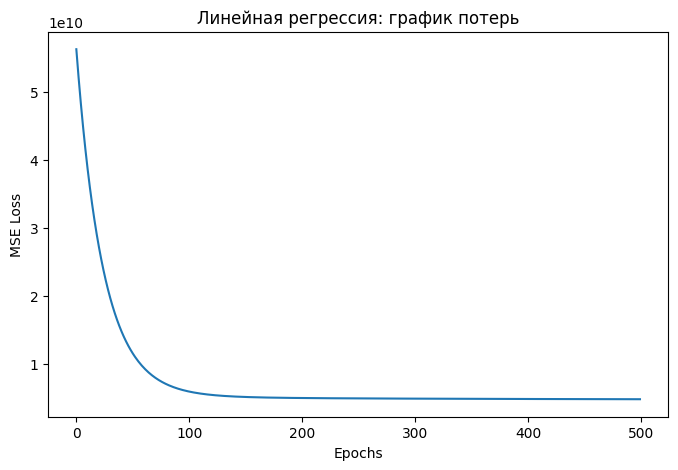

Весовые коэффициенты: [-17551.44607282 -16290.09643772  14597.62926042   4284.80781478
  18859.44722778 -32555.81134372  15843.71313959  72050.10220567
 -30242.56956601   2406.72824393    151.12969838   3415.42586803]
Интерсепт: 207186.1937858447


In [24]:
lr_model = LinearRegressionGD(lr=0.01, epochs=500)
lr_model.fit(X_train, y_train_reg)

plt.figure(figsize=(8,5))
plt.plot(lr_model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Линейная регрессия: график потерь")
plt.show()

print("Весовые коэффициенты:", lr_model.w)
print("Интерсепт:", lr_model.b)


In [25]:
class LogisticRegressionGD:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = None
        self.loss_history = []

    def sigmoid(self, z):
        return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for i in range(self.epochs):
            linear_model = np.dot(X, self.w) + self.b
            y_pred = self.sigmoid(linear_model)
            loss = -np.mean(y*np.log(y_pred + 1e-15) + (1-y)*np.log(1-y_pred + 1e-15))
            self.loss_history.append(loss)

            dw = np.dot(X.T, (y_pred - y)) / n_samples
            db = np.sum(y_pred - y) / n_samples

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict_prob(self, X):
        return self.sigmoid(np.dot(X, self.w) + self.b)

    def predict(self, X, threshold=0.5):
        return (self.predict_prob(X) >= threshold).astype(int)


In [26]:
log_model = LogisticRegressionGD(lr=0.1, epochs=500)
log_model.fit(X_train, y_train_clf)

y_pred_prob = log_model.predict_prob(X_test)
y_pred_clf = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print("Precision:", precision_score(y_test_clf, y_pred_clf))
print("Recall:", recall_score(y_test_clf, y_pred_clf))
print("F1-score:", f1_score(y_test_clf, y_pred_clf))
print("Confusion Matrix:\n", confusion_matrix(y_test_clf, y_pred_clf))
print("ROC AUC:", roc_auc_score(y_test_clf, y_pred_prob))


Accuracy: 0.8161337209302325
Precision: 0.8120772946859903
Recall: 0.8196001950268161
F1-score: 0.8158214025721913
Confusion Matrix:
 [[1688  389]
 [ 370 1681]]
ROC AUC: 0.9051089373127756


In [27]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_clf)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test_clf, y_pred_rf))
print("Precision:", precision_score(y_test_clf, y_pred_rf))
print("Recall:", recall_score(y_test_clf, y_pred_rf))
print("F1-score:", f1_score(y_test_clf, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test_clf, y_pred_rf))


Random Forest Accuracy: 0.8851744186046512
Precision: 0.8811019816336394
Recall: 0.8888347147732814
F1-score: 0.8849514563106796
Confusion Matrix:
 [[1831  246]
 [ 228 1823]]


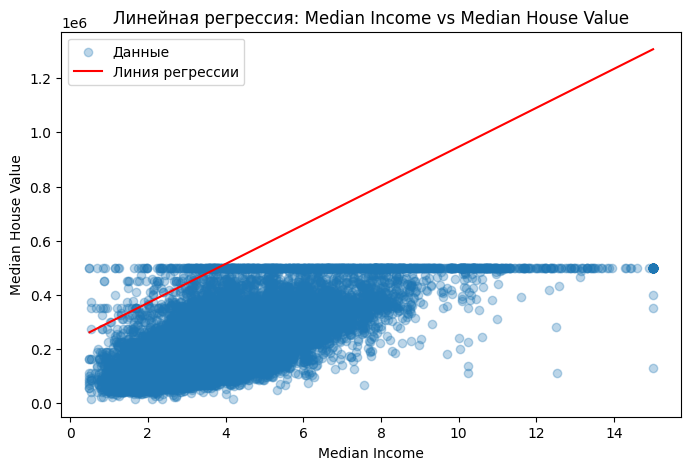

In [28]:
plt.figure(figsize=(8,5))
plt.scatter(df['median_income'], df['median_house_value'], alpha=0.3, label='Данные')

# Линия предсказаний (по median_income)
x_vals = np.linspace(df['median_income'].min(), df['median_income'].max(), 100)
X_plot = np.zeros((100, X_train.shape[1]))
# Используем median для остальных признаков
medians = np.median(X_train, axis=0)
X_plot[:] = medians
X_plot[:, 7] = x_vals  # индекс median_income после one-hot
y_vals = lr_model.predict(X_plot)

plt.plot(x_vals, y_vals, color='red', label='Линия регрессии')
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Линейная регрессия: Median Income vs Median House Value")
plt.legend()
plt.show()


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
from tqdm import tqdm

# ==================== 1. ОПРЕДЕЛЕНИЕ КЛАССОВ ====================

class LinearRegressionGD:
    """Линейная регрессия с градиентным спуском"""

    def __init__(self, learning_rate=0.01, n_iter=1000, batch_size=None):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X, y):
        """Обучение модели"""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for iteration in tqdm(range(self.n_iter), desc="Обучение линейной регрессии"):
            # Мини-батч градиентный спуск
            if self.batch_size and self.batch_size < n_samples:
                indices = np.random.choice(n_samples, self.batch_size, replace=False)
                X_batch = X[indices]
                y_batch = y[indices]
            else:
                X_batch = X
                y_batch = y

            # Прямое распространение
            y_pred = np.dot(X_batch, self.weights) + self.bias

            # Вычисление градиентов
            dw = (1/len(y_batch)) * np.dot(X_batch.T, (y_pred - y_batch))
            db = (1/len(y_batch)) * np.sum(y_pred - y_batch)

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Вычисление потерь
            loss = self.compute_loss(X, y)
            self.loss_history.append(loss)

        return self

    def compute_loss(self, X, y):
        """Вычисление MSE"""
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)

    def predict(self, X):
        """Предсказание"""
        return np.dot(X, self.weights) + self.bias

class LogisticRegressionGD:
    """Логистическая регрессия с градиентным спуском"""

    def __init__(self, learning_rate=0.01, n_iter=1000, reg_strength=0.1):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.reg_strength = reg_strength
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        """Сигмоидная функция"""
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """Обучение модели"""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for iteration in tqdm(range(self.n_iter), desc="Обучение логистической регрессии"):
            # Прямое распространение
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            # Вычисление градиентов (с регуляризацией L2)
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y)) + (self.reg_strength/n_samples) * self.weights
            db = (1/n_samples) * np.sum(y_pred - y)

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Вычисление потерь
            loss = self.compute_loss(X, y)
            self.loss_history.append(loss)

        return self

    def compute_loss(self, X, y):
        """Вычисление log loss"""
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)

        # Log loss с регуляризацией L2
        log_loss = -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
        reg_loss = (self.reg_strength / (2 * len(y))) * np.sum(self.weights ** 2)

        return log_loss + reg_loss

    def predict_proba(self, X):
        """Вероятности предсказаний"""
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        """Бинарные предсказания"""
        return (self.predict_proba(X) >= threshold).astype(int)

# ==================== 2. ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ ====================

# Загрузка данных
print("Загрузка данных...")
data = pd.read_csv('housing.csv')

def preprocess_data(df):
    """Предобработка данных"""
    df = df.copy()

    # Обработка пропущенных значений
    df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

    # Кодирование категориальных признаков
    df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

    # Создание новых признаков
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    df['population_per_household'] = df['population'] / df['households']

    return df

def create_binary_target(df, threshold_percentile=75):
    """Создание бинарной целевой переменной"""
    threshold = np.percentile(df['median_house_value'], threshold_percentile)
    df['is_expensive'] = (df['median_house_value'] > threshold).astype(int)
    return df, threshold

print("Предобработка данных...")
df = preprocess_data(data)

# Подготовка данных для линейной регрессии
print("Подготовка данных для линейной регрессии...")
features_reg = ['median_income', 'housing_median_age', 'total_rooms',
               'bedrooms_per_room', 'population_per_household']
X_reg = df[features_reg].values
y_reg = df['median_house_value'].values

scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)
y_reg_scaled = (y_reg - y_reg.mean()) / y_reg.std()

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg_scaled, test_size=0.2, random_state=42
)

# Подготовка данных для логистической регрессии
print("Подготовка данных для логистической регрессии...")
df, threshold = create_binary_target(df)
print(f"Порог для дорогого жилья: ${threshold:.0f}")
print(f"Процент дорогих домов: {df['is_expensive'].mean()*100:.1f}%")

features_clf = ['median_income', 'housing_median_age', 'total_rooms',
               'bedrooms_per_room', 'population_per_household',
               'rooms_per_household']
X_clf = df[features_clf].values
y_clf = df['is_expensive'].values

scaler_clf = StandardScaler()
X_clf_scaled = scaler_clf.fit_transform(X_clf)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf_scaled, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("============================================================")
print("ДАННЫЕ ГОТОВЫ К ИСПОЛЬЗОВАНИЮ")
print("============================================================")
print(f"Линейная регрессия: {X_train_reg.shape[0]} тренировочных, {X_test_reg.shape[0]} тестовых")
print(f"Логистическая регрессия: {X_train_clf.shape[0]} тренировочных, {X_test_clf.shape[0]} тестовых")
print(f"Классы: {np.bincount(y_train_clf)[0]} дешевых, {np.bincount(y_train_clf)[1]} дорогих")

# ==================== 3. ИНТЕРАКТИВНАЯ ФУНКЦИЯ ====================

def interactive_train(model_name, lr, epochs):
    plt.figure(figsize=(15, 4))

    if model_name == "Linear Regression":
        # Обучаем линейную регрессию
        model = LinearRegressionGD(learning_rate=lr, n_iter=epochs, batch_size=100)
        model.fit(X_train_reg, y_train_reg)

        # Предсказания
        y_train_pred = model.predict(X_train_reg)
        y_test_pred = model.predict(X_test_reg)

        # Вычисляем метрики
        train_mse = model.compute_loss(X_train_reg, y_train_reg)
        test_mse = model.compute_loss(X_test_reg, y_test_reg)

        # Вычисляем R² score
        def r2_score_local(y_true, y_pred):
            ss_res = np.sum((y_true - y_pred) ** 2)
            ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
            return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

        r2_train = r2_score_local(y_train_reg, y_train_pred)
        r2_test = r2_score_local(y_test_reg, y_test_pred)

        # График 1: Функция потерь
        plt.subplot(1, 3, 1)
        plt.plot(model.loss_history)
        plt.xlabel("Epochs")
        plt.ylabel("MSE Loss")
        plt.title(f"Linear Regression Loss\nLR={lr}, Epochs={epochs}")
        plt.grid(True, alpha=0.3)

        # График 2: Предсказания vs Фактические значения
        plt.subplot(1, 3, 2)
        plt.scatter(y_test_reg[:100], y_test_pred[:100], alpha=0.5)
        plt.plot([y_test_reg.min(), y_test_reg.max()],
                [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
        plt.xlabel("Actual Values (scaled)")
        plt.ylabel("Predicted Values (scaled)")
        plt.title("Predictions vs Actual (100 samples)")
        plt.grid(True, alpha=0.3)

        # График 3: Коэффициенты модели
        plt.subplot(1, 3, 3)
        feature_names = ['median_income', 'house_age', 'total_rooms', 'bed/room', 'pop/household']
        colors = ['green' if w > 0 else 'red' for w in model.weights]
        plt.barh(feature_names, model.weights, color=colors)
        plt.xlabel("Coefficient Value")
        plt.title("Feature Coefficients")
        plt.grid(True, alpha=0.3, axis='x')

        plt.tight_layout()
        plt.show()

        # Вывод метрик
        print("============================================================")
        print("LINEAR REGRESSION RESULTS")
        print("============================================================")
        print(f"Hyperparameters:")
        print(f"  Learning Rate: {lr}")
        print(f"  Epochs: {epochs}")
        print(f"  Batch Size: 100")

        print(f"\nTraining Metrics:")
        print(f"  Final Training MSE: {train_mse:.4f}")
        print(f"  Training R²:        {r2_train:.4f}")
        print(f"  Final Training Loss: {model.loss_history[-1]:.4f}")

        print(f"\nTest Metrics:")
        print(f"  Test MSE: {test_mse:.4f}")
        print(f"  Test R²:  {r2_test:.4f}")

        print(f"\nModel Parameters:")
        print(f"  Weights: [{', '.join([f'{w:.4f}' for w in model.weights])}]")
        print(f"  Bias: {model.bias:.4f}")

        # Анализ качества
        print(f"\nAnalysis:")
        if test_mse < train_mse:
            print(f"  Model generalizes well (test MSE < train MSE)")
        elif test_mse - train_mse < 0.05:
            print(f"  Model generalizes adequately")
        else:
            print(f"  Model might be overfitting (test MSE > train MSE)")

        print(f"\nR² Interpretation:")
        if r2_test > 0.7:
            print(f"  Excellent fit (R² > 0.7)")
        elif r2_test > 0.5:
            print(f"  Good fit (R² > 0.5)")
        elif r2_test > 0.3:
            print(f"  Moderate fit (R² > 0.3)")
        else:
            print(f"  Weak fit (R² ≤ 0.3)")

        if model.loss_history[-1] < 0.3:
            print(f"  Good convergence achieved")
        else:
            print(f"  Consider increasing epochs or adjusting learning rate")

        # Проверка на NaN
        if np.isnan(model.loss_history[-1]):
            print(f"  WARNING: Loss is NaN! Reduce learning rate.")

    else:  # Logistic Regression
        # Обучаем логистическую регрессию
        model = LogisticRegressionGD(learning_rate=lr, n_iter=epochs, reg_strength=0.1)
        model.fit(X_train_clf, y_train_clf)

        # Предсказания
        y_train_pred = model.predict(X_train_clf)
        y_test_pred = model.predict(X_test_clf)
        y_test_proba = model.predict_proba(X_test_clf)

        # Вычисляем метрики
        train_acc = accuracy_score(y_train_clf, y_train_pred)
        test_acc = accuracy_score(y_test_clf, y_test_pred)
        precision = precision_score(y_test_clf, y_test_pred)
        recall = recall_score(y_test_clf, y_test_pred)
        f1 = f1_score(y_test_clf, y_test_pred)
        auc_score_val = roc_auc_score(y_test_clf, y_test_proba)

        # Confusion matrix
        cm = confusion_matrix(y_test_clf, y_test_pred)

        # График 1: Функция потерь
        plt.subplot(1, 4, 1)
        plt.plot(model.loss_history)
        plt.xlabel("Epochs")
        plt.ylabel("Log Loss")
        plt.title(f"Logistic Regression Loss\nLR={lr}, Epochs={epochs}")
        plt.grid(True, alpha=0.3)

        # График 2: Confusion Matrix
        plt.subplot(1, 4, 2)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

        # График 3: ROC Curve
        plt.subplot(1, 4, 3)
        fpr, tpr, _ = roc_curve(y_test_clf, y_test_proba)
        plt.plot(fpr, tpr, 'b-', label=f'AUC = {auc_score_val:.3f}')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # График 4: Метрики в виде столбчатой диаграммы
        plt.subplot(1, 4, 4)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
        values = [test_acc, precision, recall, f1]
        colors = ['blue', 'green', 'orange', 'red']
        bars = plt.bar(metrics, values, color=colors)
        plt.ylim(0, 1)
        plt.ylabel("Score")
        plt.title("Model Metrics")

        # Добавляем значения на столбцы
        for bar, val in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{val:.3f}', ha='center', va='bottom')

        plt.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

        # Вывод метрик
        print("============================================================")
        print("LOGISTIC REGRESSION RESULTS")
        print("============================================================")
        print(f"Hyperparameters:")
        print(f"  Learning Rate: {lr}")
        print(f"  Epochs: {epochs}")
        print(f"  Regularization Strength: 0.1")

        print(f"\nTraining Metrics:")
        print(f"  Training Accuracy: {train_acc:.4f} ({train_acc*100:.1f}%)")
        print(f"  Final Training Loss: {model.loss_history[-1]:.4f}")

        print(f"\nTest Metrics:")
        print(f"  Test Accuracy:    {test_acc:.4f} ({test_acc*100:.1f}%)")
        print(f"  Precision:        {precision:.4f}")
        print(f"  Recall:           {recall:.4f}")
        print(f"  F1-Score:         {f1:.4f}")
        print(f"  AUC-ROC:          {auc_score_val:.4f}")

        # Подробная confusion matrix
        tn, fp, fn, tp = cm.ravel()
        print(f"\nConfusion Matrix Details:")
        print(f"  True Negatives:  {tn} (правильно предсказанные дешевые)")
        print(f"  False Positives: {fp} (дорогие предсказаны как дешевые)")
        print(f"  False Negatives: {fn} (дешевые предсказаны как дорогие)")
        print(f"  True Positives:  {tp} (правильно предсказанные дорогие)")

        # Дополнительные вычисления
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"  Specificity:      {specificity:.4f}")

        print(f"\nAnalysis:")
        if test_acc > 0.8:
            print(f"  Excellent classification accuracy (>80%)")
        elif test_acc > 0.7:
            print(f"  Good classification accuracy (>70%)")
        else:
            print(f"  Moderate classification accuracy - consider tuning")

        if precision > 0.7 and recall > 0.6:
            print(f"  Balanced precision and recall")
        elif precision > recall:
            print(f"  Model is conservative (fewer false positives)")
        else:
            print(f"  Model captures more positives (fewer false negatives)")

        if model.loss_history[-1] < 0.5:
            print(f"  Good convergence achieved")
        else:
            print(f"  Consider adjusting learning rate or increasing epochs")

        if np.isnan(model.loss_history[-1]):
            print(f"  WARNING: Loss is NaN! Reduce learning rate.")

# ==================== 4. ЗАПУСК ИНТЕРАКТИВНОГО ИНТЕРФЕЙСА ====================

print("\n============================================================")
print("ИНТЕРАКТИВНОЕ ОБУЧЕНИЕ МОДЕЛЕЙ")
print("============================================================")
print("Используйте слайдеры для настройки параметров:")
print("1. Выберите модель")
print("2. Настройте learning rate (0.001-0.5)")
print("3. Настройте количество эпох (100-2000)")
print("\nМодель начнет обучаться автоматически при изменении параметров")

interact(
    interactive_train,
    model_name=Dropdown(options=["Linear Regression", "Logistic Regression"],
                       value="Linear Regression",
                       description="Модель:"),
    lr=FloatSlider(min=0.001, max=0.5, step=0.001, value=0.01,
                  description="Learning rate:"),
    epochs=IntSlider(min=100, max=2000, step=50, value=500,
                    description="Эпохи:")
)

Загрузка данных...
Предобработка данных...
Подготовка данных для линейной регрессии...
Подготовка данных для логистической регрессии...
Порог для дорогого жилья: $264725
Процент дорогих домов: 25.0%
ДАННЫЕ ГОТОВЫ К ИСПОЛЬЗОВАНИЮ
Линейная регрессия: 16512 тренировочных, 4128 тестовых
Логистическая регрессия: 16512 тренировочных, 4128 тестовых
Классы: 12384 дешевых, 4128 дорогих

ИНТЕРАКТИВНОЕ ОБУЧЕНИЕ МОДЕЛЕЙ
Используйте слайдеры для настройки параметров:
1. Выберите модель
2. Настройте learning rate (0.001-0.5)
3. Настройте количество эпох (100-2000)

Модель начнет обучаться автоматически при изменении параметров


interactive(children=(Dropdown(description='Модель:', options=('Linear Regression', 'Logistic Regression'), va…

<function __main__.interactive_train(model_name, lr, epochs)>